C:\Users\15261\AppData\Local\Temp\ipykernel_15264\3487180051.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  H_BHPF[u, v] = 1 / (1 + (D0 / D[u, v]) ** (2 * n))


20.208761809750214
24.126535929551935
14.831644986050932
9.989098703800591
0.34820393342177625
0.5994629536337404
0.3528286144370881
0.004059182198550858


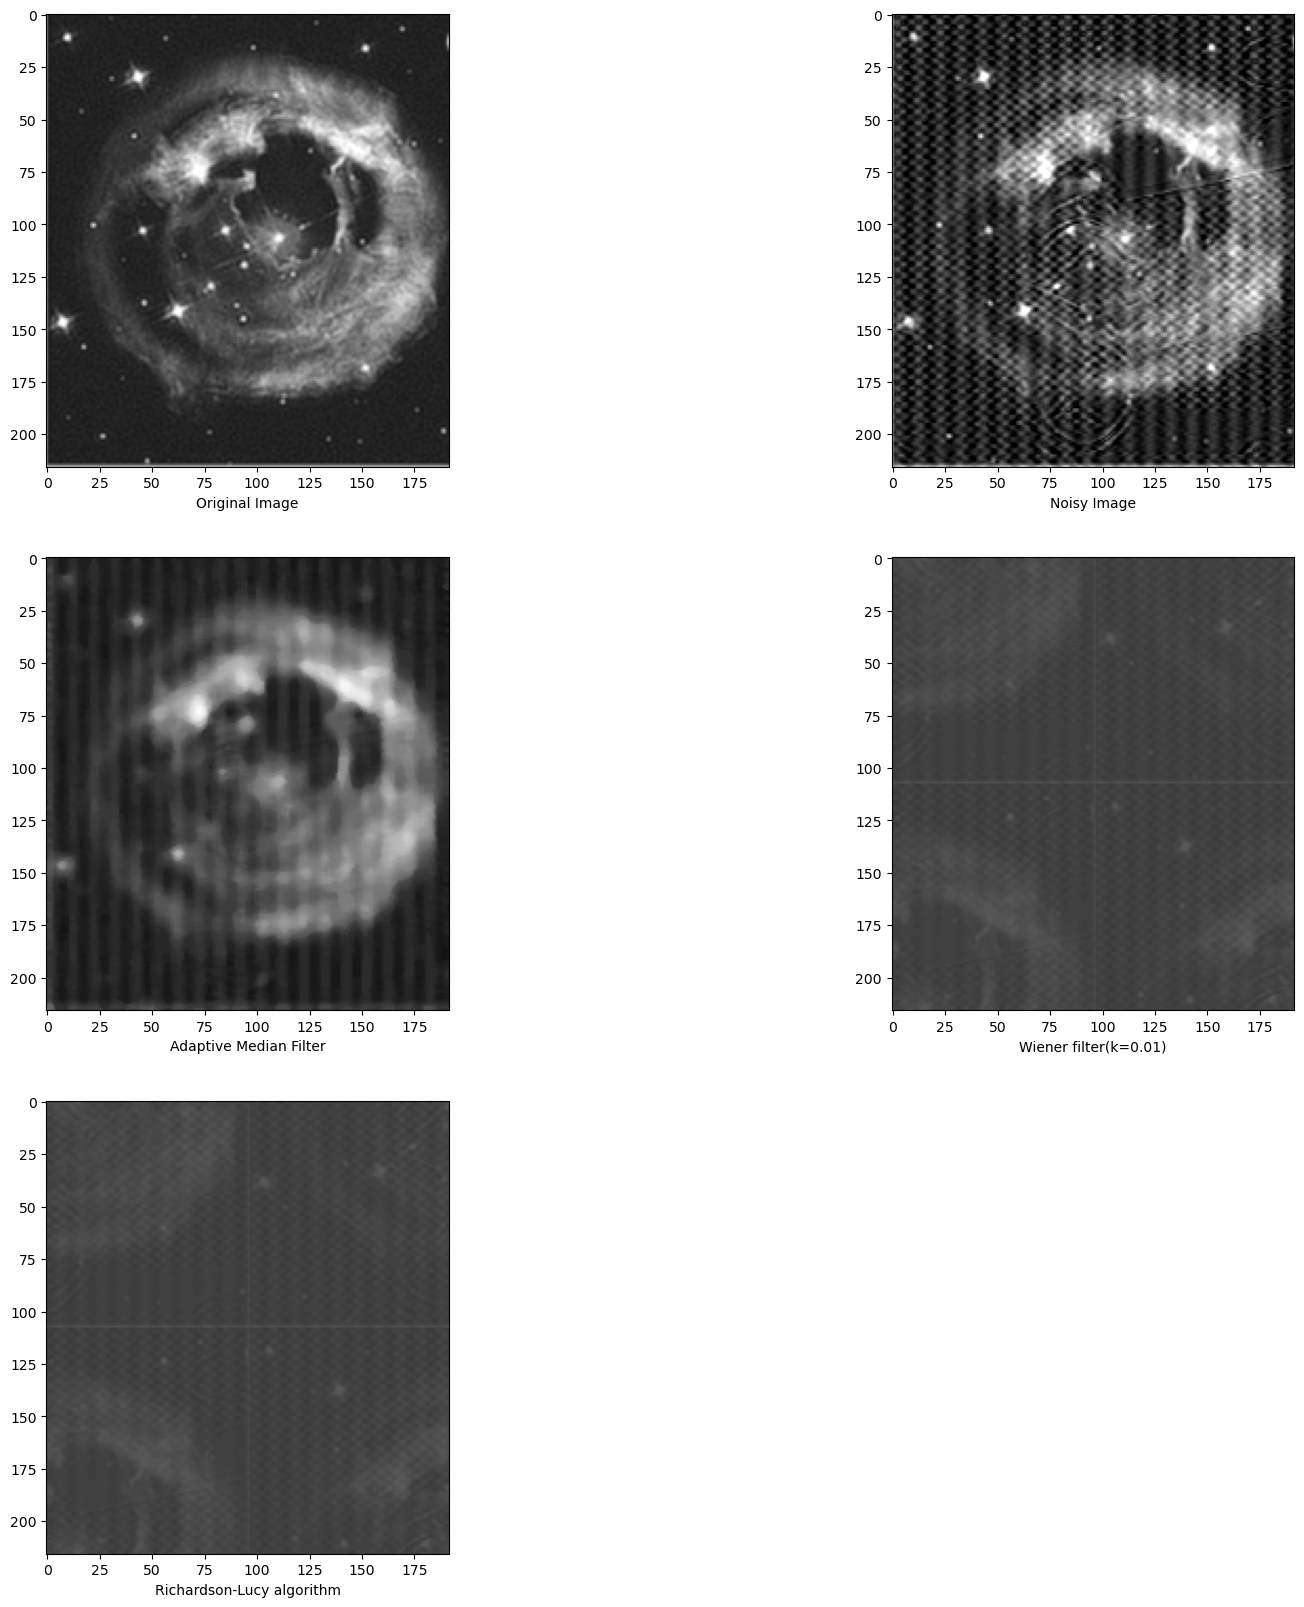

In [4]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import fft
from skimage import color, data, restoration, filters
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from matplotlib.colors import LogNorm


def add_periodic_noise(img, mean, amplitude, frequency):
    rows, cols = img.shape 
    noise = np.zeros((rows, cols)) 
    for i in range(rows):
        for j in range(cols):
            noise[i, j] = mean + amplitude * np.sin(2 * np.pi * frequency * j)
    return img + noise


def gasuss_noise(image, mu=0.0, sigma=0.1):
    image = np.array(image / 255, dtype=float)
    noise = np.random.normal(mu, sigma, image.shape)
    gauss_noise = image + noise
    if gauss_noise.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.
    gauss_noise = np.clip(gauss_noise, low_clip, 1.0)
    gauss_noise = np.uint8(gauss_noise * 255)
    return gauss_noise


# def motion_process(image_size, motion_angle):
#     PSF = np.zeros(image_size)
#     center_position = (image_size[0] - 1) / 2
#     slope_tan = math.tan(motion_angle * math.pi / 180)
#     slope_cot = 1 / slope_tan
#     if slope_tan <= 1:
#         for i in range(30):
#             offset = round(i * slope_tan)  # ((center_position-i)*slope_tan)
#             PSF[int(center_position + offset), int(center_position - offset)] = 1
#         return PSF / PSF.sum()  # Normalize brightness to point spread function
#     else:
#         for i in range(30):
#             offset = round(i * slope_cot)
#             PSF[int(center_position - offset), int(center_position + offset)] = 1
#         return PSF / PSF.sum()
    
    
def make_blurred(input, PSF, eps):
    input_fft = fft.fft2(input)  # Take Fourier Transform of a 2D Array
    PSF_fft = fft.fft2(PSF) + eps
    blurred = fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(fft.fftshift(blurred))
    return blurred


def display_img(img_name, title, gray=True):
    if gray:
        plt.imshow(img_name, vmin=0, vmax=255, cmap="gray")
    else:
        plt.imshow(img_name.astype('uint8'),vmin=0,vmax=255)
    plt.title(title)
    plt.show()

    
def get_img_fft_shift(img):
    img_fft = np.fft.fft2(img)
    img_fft_shift = np.fft.fftshift(img_fft)
    return img_fft_shift


def show_DFT_magnitude(img_fft_shift, title):
    # img_fft = np.fft.fft2(img)
    # img_fft_shift = np.fft.fftshift(img_fft)
    plt.imshow(np.abs(img_fft_shift), cmap="gray", norm=LogNorm(vmin=5))
    plt.title(title)
    plt.show()


def inverse(input, PSF, eps):  # Inverse filtering
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps  # noise power, which is known, considering epsilon
    result = fft.ifft2(input_fft / PSF_fft)  # Compute the inverse Fourier transform of F(u,v)
    result = np.abs(fft.fftshift(result))
    return result


def wiener(input, PSF, eps, K=0.01):  # Wiener filter, K=0.01
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps
    wiener_filter = 1 / PSF_fft * np.abs(PSF_fft) ** 2 / (np.abs(PSF_fft) ** 2 + K)
    result = fft.ifft2(input_fft * wiener_filter)
    result = np.abs(fft.fftshift(result))
    return result


def constrained_ls_filter(img, kernel, laplacian, gamma):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.fft.fftshift(np.fft.fft2(dummy))
    kernel = np.fft.fftshift(np.fft.fft2(kernel, s=img.shape))
    P = np.fft.fftshift(np.fft.fft2(laplacian, s=img.shape))
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + gamma * P)
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(np.fft.ifftshift(dummy)))
    return dummy


def BHPF(M, N, D0, n, uk, vk):
    H_BHPF = np.zeros((M, N))
    D = np.zeros((M, N))
    for u in range(M):
        for v in range(N):
            D[u, v] = np.sqrt((u - M / 2 - uk) ** 2 + (
                    v - N / 2 - vk) ** 2)  # euclidean distance from (u,v) to ((uk,vk) related to center)
            H_BHPF[u, v] = 1 / (1 + (D0 / D[u, v]) ** (2 * n))
    return H_BHPF


# implement Butterworth notch reject filter
def notchFilter(img, n, UV_set):  # n is the parameter of the Butterworth highpass filter
    # Q is the number of Butterworth highpass filter pairs
    M, N = img.shape
    # initialize the filter
    H_notch = np.zeros((M, N))
    length_set = len(UV_set)
    for i in range(length_set):
        uk, vk, D0 = UV_set[i]
        if i == 0:
            H_notch = BHPF(M, N, D0, n, uk, vk) * BHPF(M, N, D0, n, -uk, -vk)
        else:
            H_notch = H_notch * BHPF(M, N, D0, n, uk, vk) * BHPF(M, N, D0, n, -uk, -vk)
    return H_notch


def img_ifft(img_fft_shift): 
    Img_inverse_fft_shift = np.fft.ifftshift(img_fft_shift)
    Img_inverse_fft=np.fft.ifft2(Img_inverse_fft_shift)
    Img_inverse_fft=np.abs(Img_inverse_fft)
    return Img_inverse_fft



# second approach, borrow Moire pattern from given image degraded by Moire pattern
# add the borrowed pattern in the frequency domain into the original image to create the Moire pattern

img_name_1="astronomy_img_1.png"
Img_astronomy_1=cv2.imread("./images/"+img_name_1, cv2.IMREAD_GRAYSCALE)
Img_astronomy_1_fft_shift=get_img_fft_shift(Img_astronomy_1)

# img_name_2="astronomy_img_mercury.jpg"
# Img_astronomy_2=cv2.imread("./../images/"+img_name_2, cv2.IMREAD_GRAYSCALE)
# Img_astronomy_2_fft_shift=get_img_fft_shift(Img_astronomy_2)
# show_DFT_magnitude(Img_astronomy_2_fft_shift,"discrete fourier transform magnitude of the second image")

# read the newspaper image
img_newspaper_name="car_newsprint.tif"
Img_newspaper=cv2.imread("./images/"+img_newspaper_name, cv2.IMREAD_GRAYSCALE)
Img_newspaper=cv2.resize(Img_newspaper,dsize=(192,216),interpolation=cv2.INTER_LINEAR)
Img_newspaper_fft_shift = get_img_fft_shift(Img_newspaper)

n=4
UV_set_newspaper=[(42, -28, 20), (84, -28, 20), (-42, -28, 20), (-84, -28, 20)]
# get the notch pass filter
Img_newspaper_notch_pass=1-notchFilter(Img_newspaper,n,UV_set_newspaper)
# add the Moire pattern
Img_astronomy_1_fft_shift_added=Img_astronomy_1_fft_shift+Img_newspaper_notch_pass*Img_newspaper_fft_shift
# use the inverse fourier transformation to view the image after the addition of the Moire pattern
def img_ifft(img_fft_shift): 
    Img_inverse_fft_shift = np.fft.ifftshift(img_fft_shift)
    Img_inverse_fft=np.fft.ifft2(Img_inverse_fft_shift)
    Img_inverse_fft=np.abs(Img_inverse_fft)
    return Img_inverse_fft


Img_astronomy_1_added_Moire=img_ifft(Img_astronomy_1_fft_shift_added)
noisy = add_periodic_noise(Img_astronomy_1_added_Moire, 0, 20, 0.1)




image = Img_astronomy_1
img_h = image.shape[0]
img_w = image.shape[1]
PSF = np.ones((img_h,img_w))/(img_h*img_w)



plt.figure(figsize=(20, 20))

plt.subplot(321)
plt.xlabel("Original Image")
plt.imshow(image, cmap='gray', vmin=0, vmax=255)


plt.subplot(322)
plt.xlabel("Noisy Image")
plt.imshow(noisy, cmap='gray', vmin=0, vmax=255)


ADF_result = filters.threshold_local(noisy, 7, 'median') # Adaptive Median Filter
plt.subplot(323)
plt.xlabel("Adaptive Median Filter")
plt.imshow(ADF_result, cmap='gray', vmin=0, vmax=255)


wiener_result = wiener(noisy, PSF, 1e-3, K=0.01)  # Wiener filter
plt.subplot(324)
plt.xlabel("Wiener filter(k=0.01)")
plt.imshow(wiener_result, cmap='gray', vmin=0, vmax=255)

rl_result = restoration.richardson_lucy(noisy/255, PSF, num_iter=10)  # Richardson-Lucy
plt.subplot(325)
plt.xlabel("Richardson-Lucy algorithm")
plt.imshow(wiener_result, cmap='gray', vmin=0, vmax=255)



psnr1 = psnr(noisy, image, data_range=255)
psnr2 = psnr(ADF_result, image, data_range=255)
psnr3 = psnr(wiener_result, image, data_range=255)
psnr4 = psnr(rl_result, image, data_range=255)
#psnr5 = psnr(notch_result, image, data_range=255)

ssim1 = ssim(noisy, image, data_range=255)
ssim2 = ssim(ADF_result, image, data_range=255)
ssim3 = ssim(wiener_result, image, data_range=255)
ssim4 = ssim(rl_result, image, data_range=255)
#ssim5 = ssim(notch_result, image, data_range=255)


print(psnr1)
print(psnr2)
print(psnr3)
print(psnr4)
#print(psnr5)
print(ssim1)
print(ssim2)
print(ssim3)
print(ssim4)
#print(ssim5)
